# moment predictions

In [110]:
#Import
import sys
sys.path.append("../lib")
import basicfunc as func
import plotlib as plib

import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16
import pymaster as nmt
import healpy as hp
import pysm3
import pysm3.units as u
import simu_lib as sim
import scipy.stats as st

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_cl(mapd,mask,b):
    fa1 = nmt.NmtField(mask, (mapd)*1,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa1, b)
    return compute_master(fa1,fa1,wsp)        

def compute_cross_cl(mapd1,mapd2,mask,b):
    fa1 = nmt.NmtField(mask, (mapd1)*1,purify_e=False, purify_b=True)
    fa2 = nmt.NmtField(mask, (mapd2)*1,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa2, b)
    return compute_master(fa1,fa2,wsp) 

def plotmed(ell,label,res,color='darkblue',marker="D",show=True,legend=''):
    """
    Plot median and median absolute deviation of best-fits as a function of ell
    :ell: bandpower array
    :label: string indicating the name of the quantity
    :color: color of the plot
    :marker: marker of the plot
    :show: show the plot
    legend: legend to add to the plot
    """
    ellbound=ell.shape[0]
    name={'A':r'$A^d$','beta':r'$\beta^d$','temp':r'$T^d$','beta_s':r'$\beta^s$','A_s':r'$A^s$','A_sd':r'$A^{sd}$','r':r'$\hat{r}$','X2red':r'$\chi^2$','Aw1b':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta}}$','Aw1t':r'$\mathcal{D}_\ell^{A\times\omega_1^{T}}$','Asw1bs':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta^s}}$','w1bw1s':r'$\mathcal{D}_\ell^{\omega_1^{\beta^d}\times\omega_1^{\beta^s}}$','w1sw1T':r'$\mathcal{D}_\ell^{\omega_1^{T^d}\times\omega_1^{\beta^s}}$','w1bw1b':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^\beta}$','w1tw1t':r'$\mathcal{D}_\ell^{\omega_1^T\times\omega_1^T}$','w1bw1t':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^T}$','w1bsw1bs':r'$\mathcal{D}_\ell^{\omega_1^{\beta^s}\times\omega_1^{\beta^s}}$', 'Asw1b':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta}}$','Asw1t':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{T}}$','Adw1s':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta^s}}$'}
    edgecolor="#80AAF3"
    plt.errorbar(ell,np.median(res[label],axis=1)[:ellbound],yerr=st.median_abs_deviation(res[label],axis=1)[:ellbound],c=color,fmt=marker,linestyle='',label=legend)
    plt.scatter(ell,np.median(res[label],axis=1)[:ellbound],s=175,c=color,marker=marker,edgecolor=edgecolor)
    plt.ylabel(name[label],fontsize=20)
    plt.xlabel(r"$\ell$",fontsize=20)
    plt.legend()
    plt.tight_layout()
    if show==True:
        plt.show()


In [111]:
#choose frequency range

dusttype=[1,10,12]
syncrotype=[0,0,0]
instr= 'LiteBIRD'
nside=64
scale=10
fsky=0.7
Nlbin = 10
lmax = nside*3-1

if fsky==1:
    mask = np.ones(hp.nside2npix(nside))
else:
    mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()

if instr=='Planck':
    freq=np.array([100,143,217,353])
if instr=='LiteBIRD':
    freq=np.array([ 40.,  50.,  60.,  68.,  78.,  89., 100., 119., 140., 166., 195.,235., 280., 337., 402.])


def getmom_downgr(mom):
    momarr=np.array([np.zeros(hp.nside2npix(512)),mom.real,mom.imag])
    momdg=sim.downgrade_map(momarr,nside_in=512,nside_out=nside)
    return momdg
def get_dl_bb_mom(map1,map2):
    return leff*(leff+1)*compute_cross_cl(getmom_downgr(map1)[1:],getmom_downgr(map2)[1:],mask,b)[3]/2/np.pi
    
def getmom(dusttype, syncrotype):
    sky = pysm3.Sky(nside=512, preset_strings=['d%s'%(dusttype),'s%s'%(syncrotype)])
    skyd = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])
    skys = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])
    dust = skyd.components[0]
    sync= skys.components[0]
    betamap =dust.mbb_index.value
    tempmap=dust.mbb_temperature.value
    betasmap =sync.pl_index.value
    if dusttype==12:
        nu0d=dust.freq_ref.value
        Ampl = dust.layers
        Amplcpxd = Ampl[:,1]+1j*Ampl[:,2]
    else:
        nu0d=dust.freq_ref_P.value
    nu0s=sync.freq_ref_P.value
        
    skyrefd = skyd.get_emission(nu0d * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0d*u.GHz)).value
    skyrefs = skys.get_emission(nu0s * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0s*u.GHz)).value

    model= np.array([sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)).value for f in range(len(freq))])
    skyrefcpxd=skyrefd[1]+1j*skyrefd[2]
    skyrefcpxs=skyrefs[1]+1j*skyrefs[2]
    betabar= 1.54
    tempbar=20
    betasbar=-3

    if dusttype ==12:
        mom1b = np.sum(Amplcpxd*(betamap-betabar),axis=0)
        mom2b = np.sum(Amplcpxd*(betamap-betabar)**2,axis=0)
        pmetbar=1/20
        pmetmap=1/tempmap
        mom1pmet = np.sum(Amplcpxd*(pmetmap-pmetbar),axis=0)

    else: 
        mom1b = skyrefcpxd*(betamap-betabar)
        mom2b = skyrefcpxd*(betamap-betabar)**2
        pmetbar=1/20
        pmetmap=1/tempmap
        mom1pmet = skyrefcpxd*(pmetmap-pmetbar)
    
    mom1bs = skyrefcpxs*(betasmap-betasbar)

    Ad= get_dl_bb_mom(skyrefcpxd,skyrefcpxd)
    As= get_dl_bb_mom(skyrefcpxs,skyrefcpxs)
    Asd=get_dl_bb_mom(skyrefcpxd,skyrefcpxs)
    w1bw1b = get_dl_bb_mom(mom1b,mom1b)
    Aw1b= get_dl_bb_mom(skyrefcpxd,mom1b)
    Asw1b= get_dl_bb_mom(skyrefcpxs,mom1b)

    Aw1p=get_dl_bb_mom(skyrefcpxd,mom1pmet)
    w1bw1p=get_dl_bb_mom(mom1b,mom1pmet)
    w1pw1p=get_dl_bb_mom(mom1pmet,mom1pmet)
    Asw1p= get_dl_bb_mom(skyrefcpxs,mom1pmet)

    return [Ad,As,Asd,w1bw1b,Aw1b,Aw1p,w1bw1p,w1pw1p,Asw1b,Asw1p]

In [112]:
a=[]
for d in range(len(dusttype)):
    a.append(getmom(dusttype[d], syncrotype[d]))

In [113]:
from scipy.optimize import curve_fit

def PL_ell(l,A,alpha):
    l0=80
    return A*(l/l0)**alpha

def plot_pl(mom):
    popt, pcov = curve_fit(PL_ell, leff[:15], mom[:15],maxfev=10000)
    plt.plot(leff[:15], PL_ell(leff[:15], *popt), '--',c='red',label=popt)

In [114]:
c=['darkblue','darkorange','darkred']
def plotres(ana):
    name=['A','A_s','A_sd','w1bw1b','Aw1b','Aw1t','w1bw1t','w1tw1t','Asw1b','Asw1t']
    for k in range(len(name)):
        plt.figure(figsize=(10,8))
        for d in range(3):
            res=np.load('../Best-fits/results_d%ss%s_%s_ds_o1bt_fix1.npy'%(dusttype[d],syncrotype[d],fsky),allow_pickle=True).item()
            plotmed(leff[:15],name[k][:15],res,color=c[d],marker="D",show=False)
            plt.plot(leff[:15],ana[d][k][:15],color=c[d],linestyle='--',label='d%ss%s'%(dusttype[d],syncrotype[d]))
            #plot_pl(ana[d][k])
        if name[k] == 'A' or name[k] == 'A_s':
            plt.loglog()
        plt.legend()
        plt.show()    

No handles with labels found to put in legend.


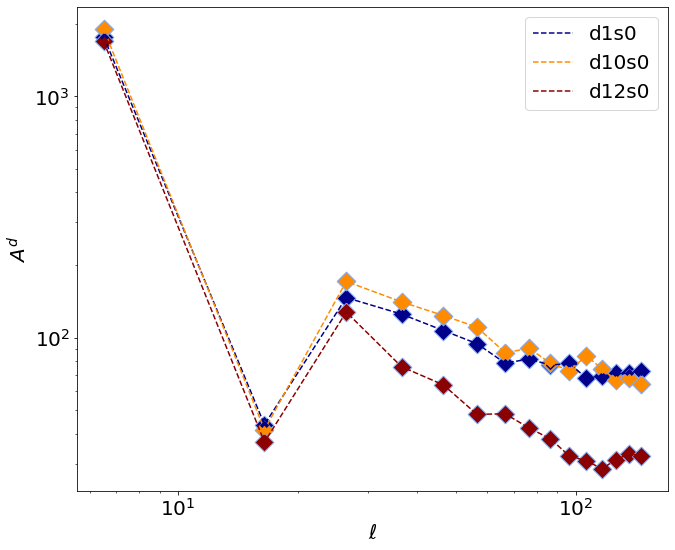

No handles with labels found to put in legend.


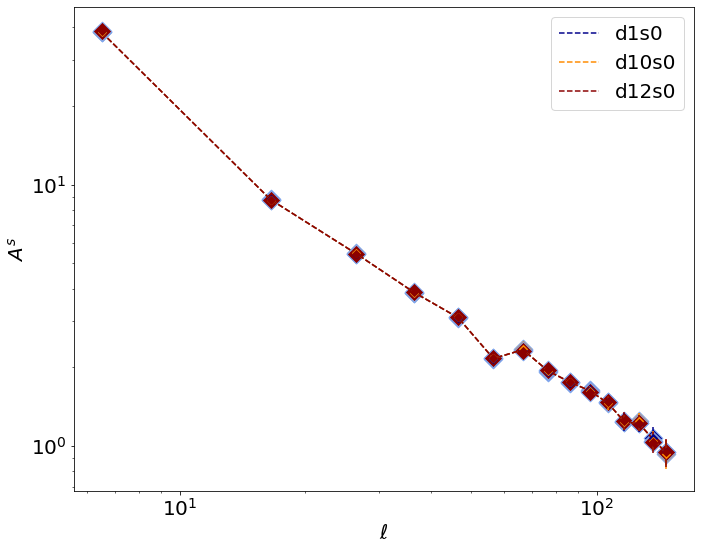

No handles with labels found to put in legend.


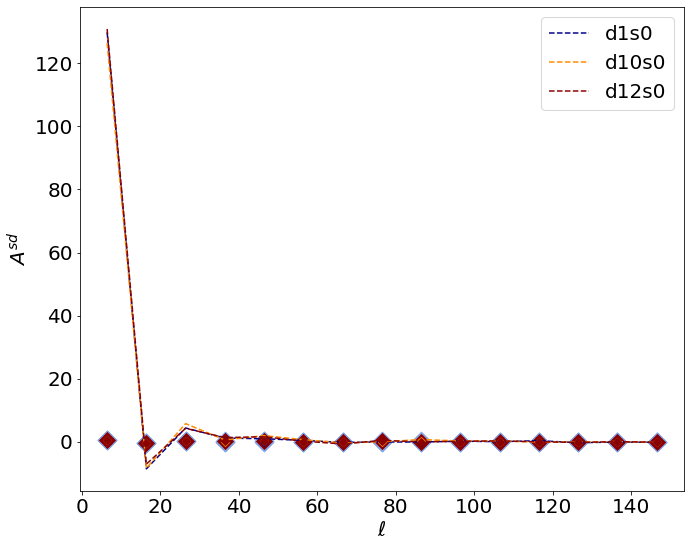

No handles with labels found to put in legend.


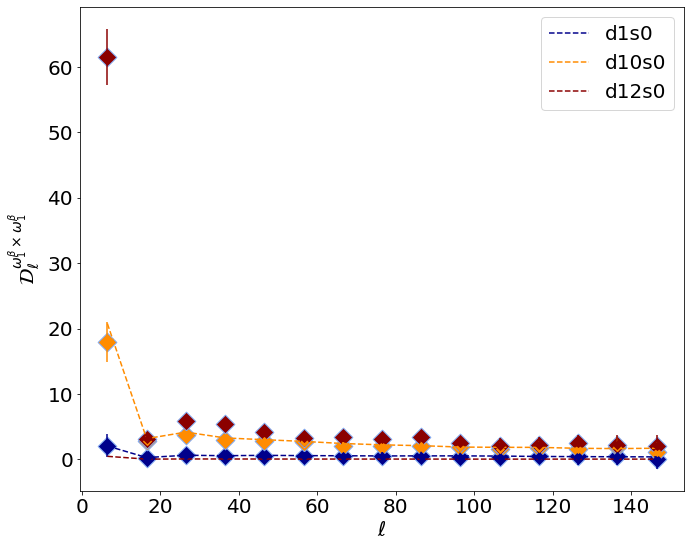

No handles with labels found to put in legend.


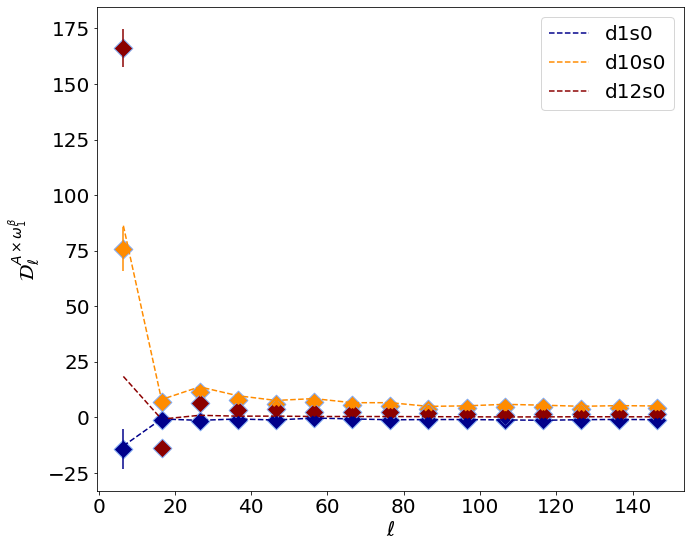

No handles with labels found to put in legend.


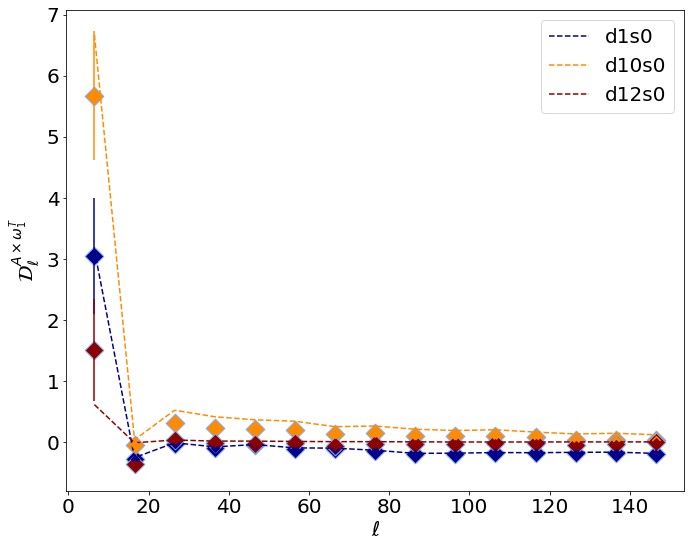

No handles with labels found to put in legend.


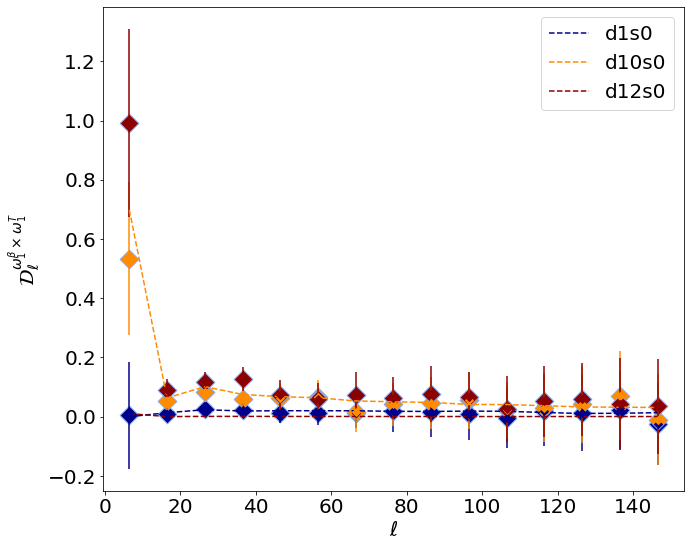

No handles with labels found to put in legend.


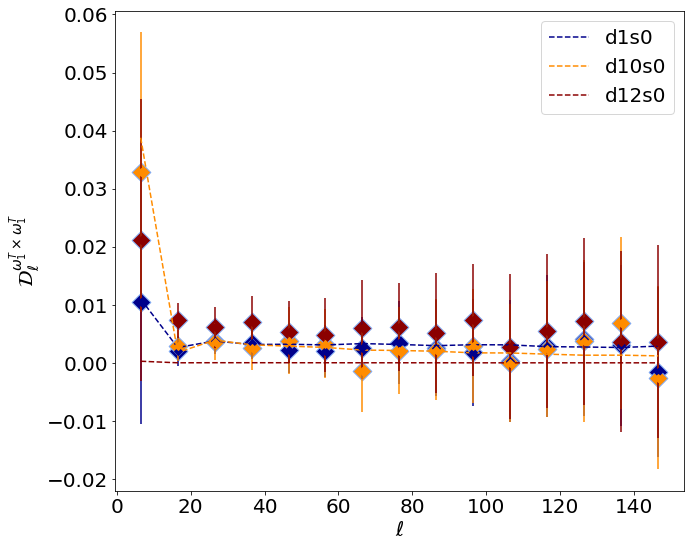

No handles with labels found to put in legend.


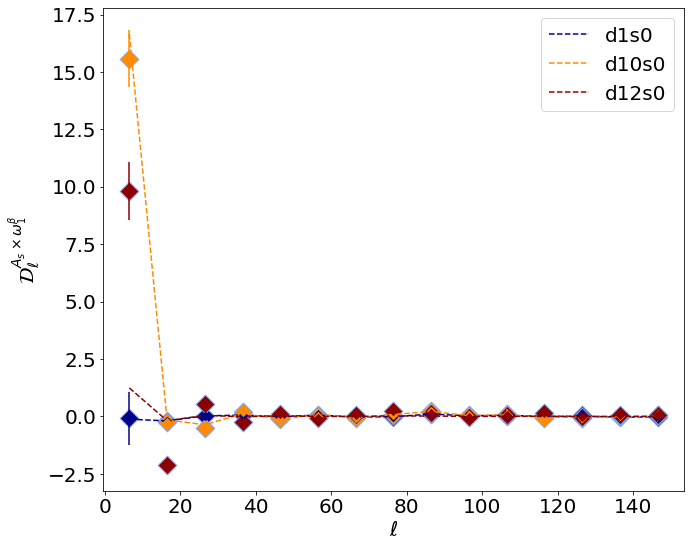

No handles with labels found to put in legend.


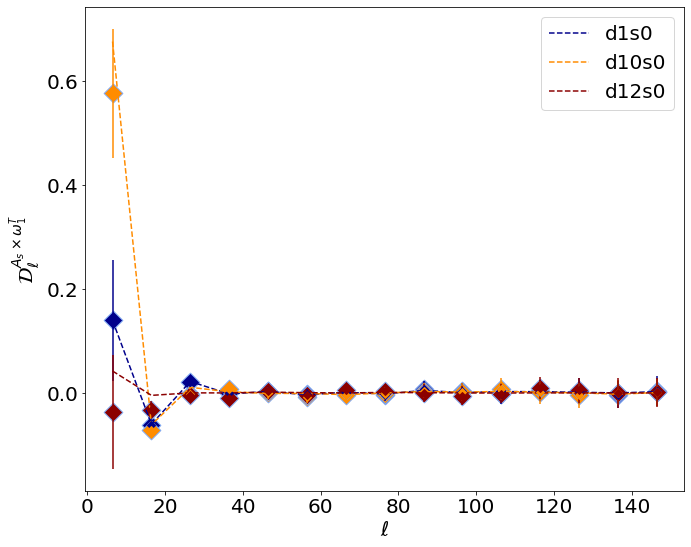

In [115]:
plotres(a)